# Cats VS Dogs Classification : 

# 📌 1. Importations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pickle
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 📌 2. Chargement des données


In [2]:
DATADIR = "Datasets/PetImages"
CATEGORIES = ["Dog", "Cat"]
IMG_SIZE = 150  # ↑ Amélioration : taille plus grande

training_data = []

def create_training_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                training_data.append([new_array, class_num])
            except:
                continue

create_training_data()
random.shuffle(training_data)

# 📌 3. Préparation des données


In [3]:
X = []
y = []
for features, label in training_data:
    X.append(features)
    y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1).astype("float32") / 255.0
y = np.array(y).astype("float32")

# 📌 4. Data Augmentation


In [4]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)
datagen.fit(X)

# 📌 5. Modèle amélioré


In [5]:
model = Sequential()

# Couche convolutionnelle 1
model.add(Conv2D(64, (3, 3), input_shape=X.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Couche convolutionnelle 2
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Couche convolutionnelle 3
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Couches finales
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout ajouté
model.add(Dense(1, activation='sigmoid'))


# 📌 6. Compilation du modèle


In [6]:
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# 📌 7. Callback EarlyStopping

In [7]:
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 📌 8. Entraînement et sauvegarde du modèle 


In [8]:
history = model.fit(
    datagen.flow(X, y, batch_size=32, subset='training'),
    validation_data=datagen.flow(X, y, batch_size=32, subset='validation'),
    epochs=30,
    callbacks=[early_stop]
)

Epoch 1/30
513/513 [==============================] - 25s 40ms/step - loss: 0.6212 - accuracy: 0.6619 - val_loss: 0.5552 - val_accuracy: 0.7230
Epoch 2/30
513/513 [==============================] - 20s 39ms/step - loss: 0.5361 - accuracy: 0.7395 - val_loss: 0.4987 - val_accuracy: 0.7623
Epoch 3/30
513/513 [==============================] - 20s 40ms/step - loss: 0.5024 - accuracy: 0.7612 - val_loss: 0.4721 - val_accuracy: 0.7737
Epoch 4/30
513/513 [==============================] - 22s 43ms/step - loss: 0.4843 - accuracy: 0.7714 - val_loss: 0.4637 - val_accuracy: 0.7801
Epoch 5/30
513/513 [==============================] - 23s 45ms/step - loss: 0.4684 - accuracy: 0.7813 - val_loss: 0.4537 - val_accuracy: 0.7876
Epoch 6/30
513/513 [==============================] - 21s 40ms/step - loss: 0.4570 - accuracy: 0.7852 - val_loss: 0.4410 - val_accuracy: 0.8020
Epoch 7/30
513/513 [==============================] - 22s 43ms/step - loss: 0.4464 - accuracy: 0.7934 - val_loss: 0.4323 - val_accuracy:

In [10]:
model.save('static/cat_dog_model.keras')

# 📌 9. Affichage des courbes d’apprentissage


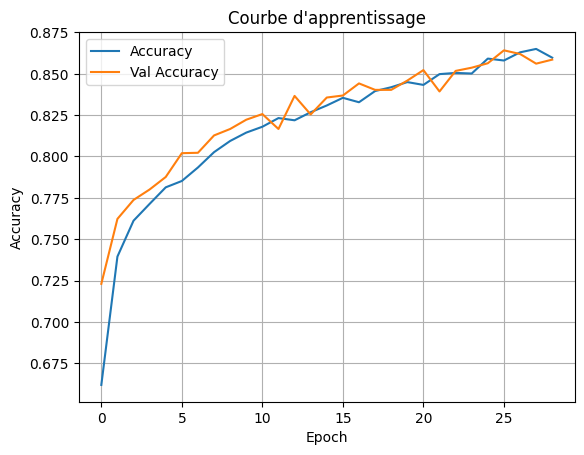

In [11]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Courbe d'apprentissage")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

641/641 [==============================] - 6s 8ms/step


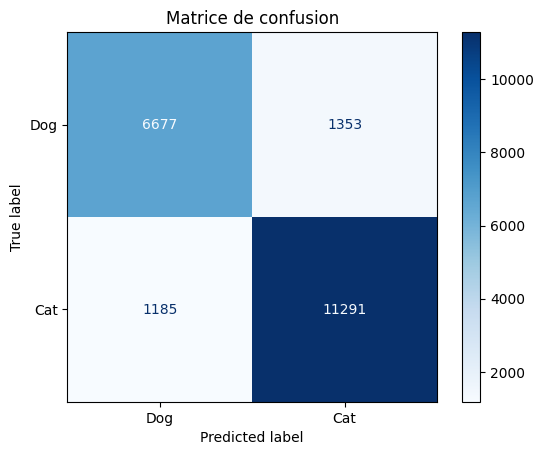

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prédictions
y_pred = model.predict(X)
y_pred_labels = (y_pred > 0.5).astype("int32")

# Matrice de confusion
cm = confusion_matrix(y, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Dog", "Cat"])
disp.plot(cmap='Blues')
plt.title("Matrice de confusion")
plt.show()


In [13]:
from sklearn.metrics import classification_report

print(classification_report(y, y_pred_labels, target_names=["Dog", "Cat"]))


              precision    recall  f1-score   support

         Dog       0.85      0.83      0.84      8030
         Cat       0.89      0.91      0.90     12476

    accuracy                           0.88     20506
   macro avg       0.87      0.87      0.87     20506
weighted avg       0.88      0.88      0.88     20506



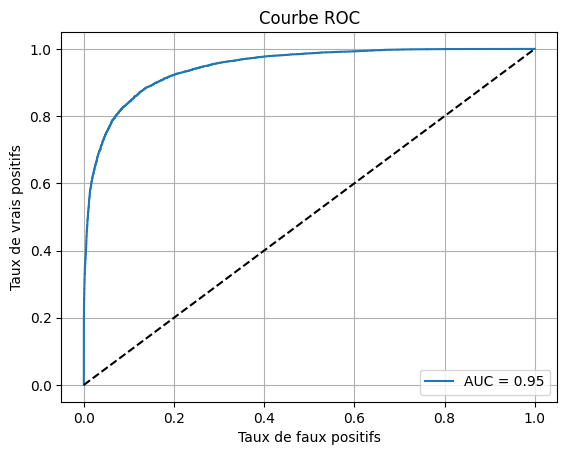

In [14]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Courbe ROC")
plt.xlabel("Taux de faux positifs")
plt.ylabel("Taux de vrais positifs")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


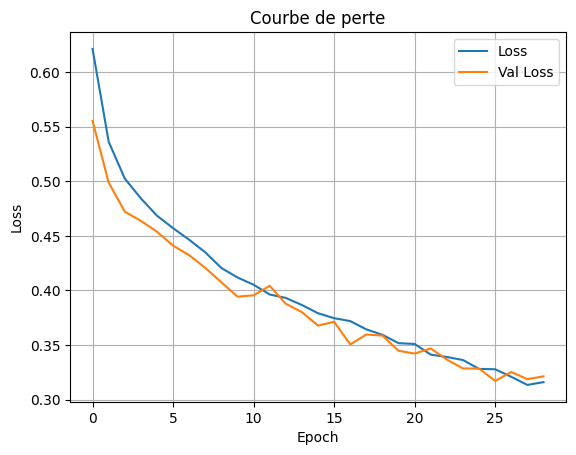

In [15]:
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Courbe de perte")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()
